In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error

import itertools
import warnings

warnings.filterwarnings('ignore')
sns.reset_defaults()


# Data Preprocessing

In [7]:
# Load the dataset
df = pd.read_csv('avg_price.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
price = df['price']
price


date
2001-01-01     6.75
2001-02-01     6.87
2001-03-01     7.01
2001-04-01     7.02
2001-05-01     7.17
              ...  
2023-09-01    13.19
2023-10-01    12.59
2023-11-01    12.50
2023-12-01    12.41
2024-01-01    12.73
Name: price, Length: 277, dtype: float64

In [31]:
df_temp = pd.read_csv('temp.csv')
df_temp['Date'] = pd.to_datetime(df_temp['Date'].astype(str), format='%Y%m')
df_temp = df_temp[(df_temp['Date'] >= '2001-01-01') & (df_temp['Date'] <= '2024-01-01')]
df_temp.set_index('Date', inplace=True)
temp = df_temp['Value']
temp_np = temp.to_numpy().reshape(-1, 1)
print(temp_np.shape)


(277, 1)


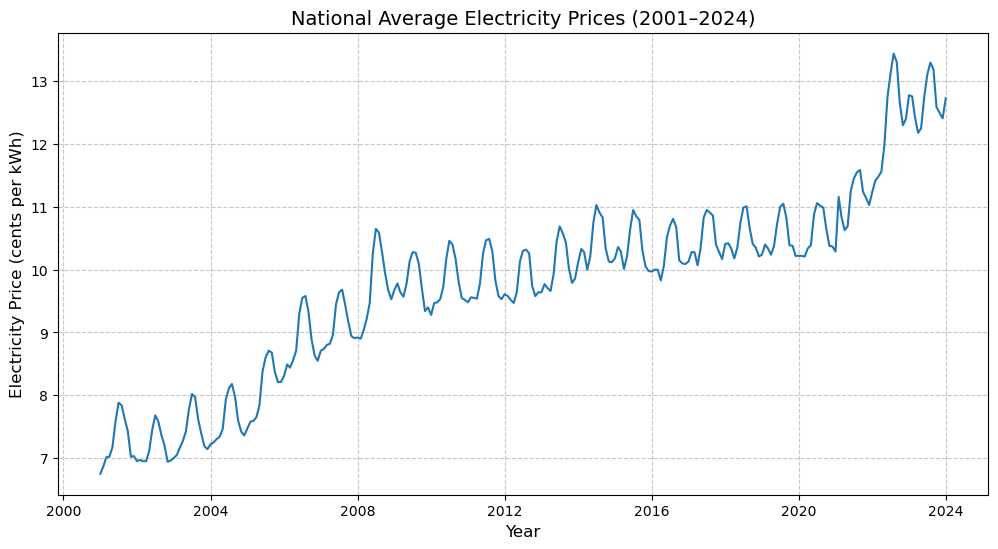

In [93]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(price)
plt.title('National Average Electricity Prices (2001–2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Electricity Price (cents per kWh)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


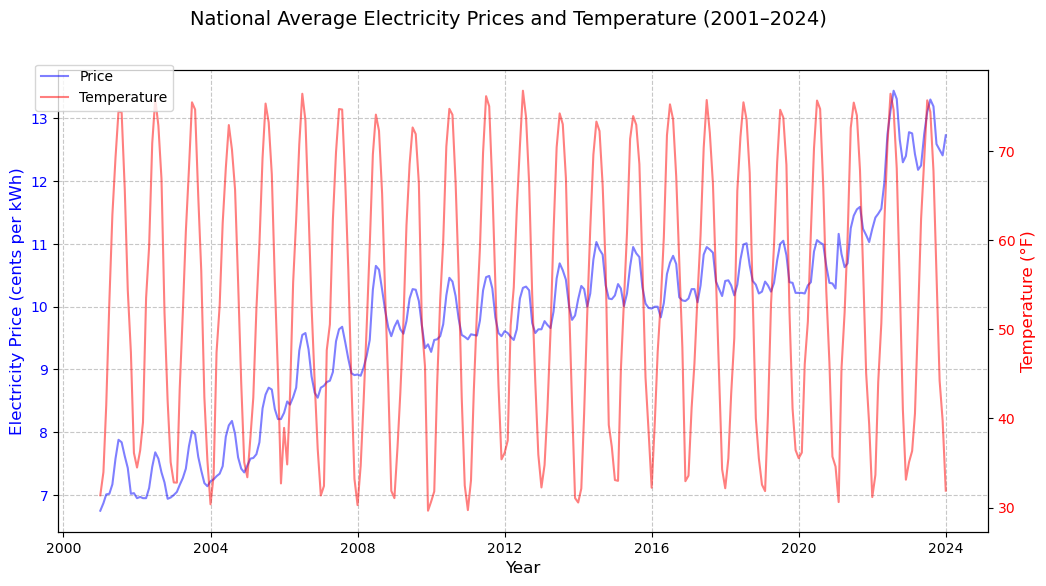

In [ ]:
# Plot the time series
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(price, label='Price', color='blue')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Electricity Price (cents per kWh)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
ax2.plot(temp, label='Temperature', color='red', alpha=0.5)
ax2.set_ylabel('Temperature (°F)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle('National Average Electricity Prices and Temperature (2001–2024)', fontsize=14)
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.show()


## Check: Stationarity? Seasonality?

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


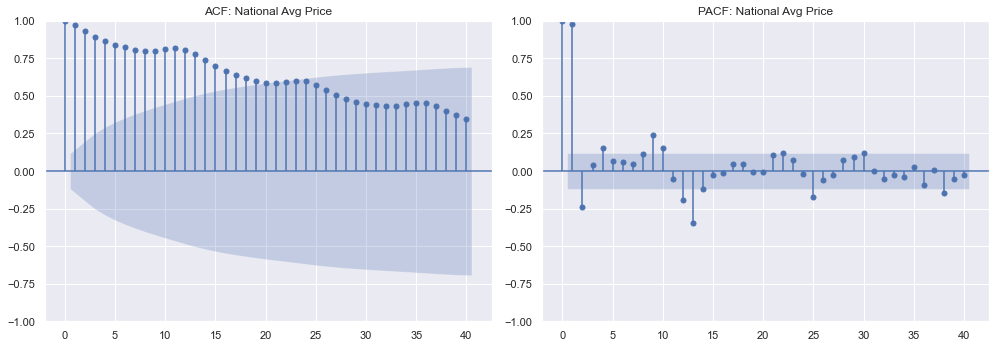

ADF Test Results:
ADF Statistic: -0.8267338300849273
p-value: 0.8111428140764292
Critical Values: {'1%': -3.455365238788105, '5%': -2.8725510317187024, '10%': -2.5726375763314966}


In [ ]:
# Perform the Augmented Dickey-Fuller (ADF) test
adf_test = adfuller(price)

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(price, lags=40, ax=axes[0], title="ACF: National Avg Price")
plot_pacf(price, lags=40, ax=axes[1], title="PACF: National Avg Price")
plt.tight_layout()
plt.show()

# Display ADF test results
adf_results = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Critical Values": adf_test[4],
}
print("ADF Test Results:")
for key, value in adf_results.items():
    print(f"{key}: {value}")

# The data is non-stationary so we will need differencing in SARIMA


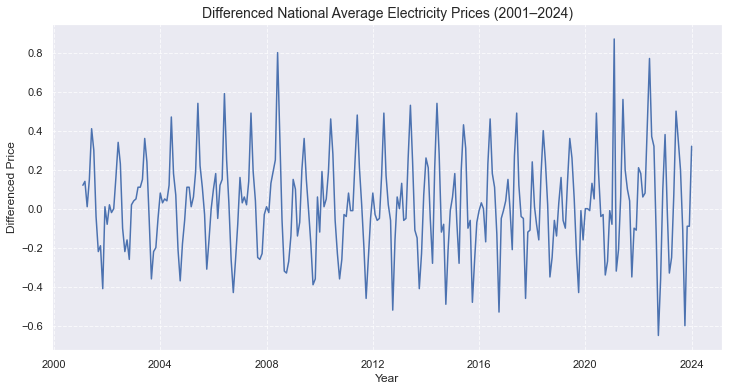

ADF Test Results after First Differencing:
ADF Statistic: -3.332271115605506
p-value: 0.01349615574734029
Critical Values: {'1%': -3.455365238788105, '5%': -2.8725510317187024, '10%': -2.5726375763314966}


In [ ]:
# Apply first differencing to the national average price
price_diff = price.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(price_diff, label='First Differenced Series')
plt.title('Differenced National Average Electricity Prices (2001–2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Differenced Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Recheck stationarity using the Augmented Dickey-Fuller test
adf_test_diff = adfuller(price_diff)

# Display ADF test results
adf_results_diff = {
    "ADF Statistic": adf_test_diff[0],
    "p-value": adf_test_diff[1],
    "Critical Values": adf_test_diff[4],
}
print("ADF Test Results after First Differencing:")
for key, value in adf_results_diff.items():
    print(f"{key}: {value}")

# Stationary after first differencing, so perhaps first order differencing is enough in SARIMA


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


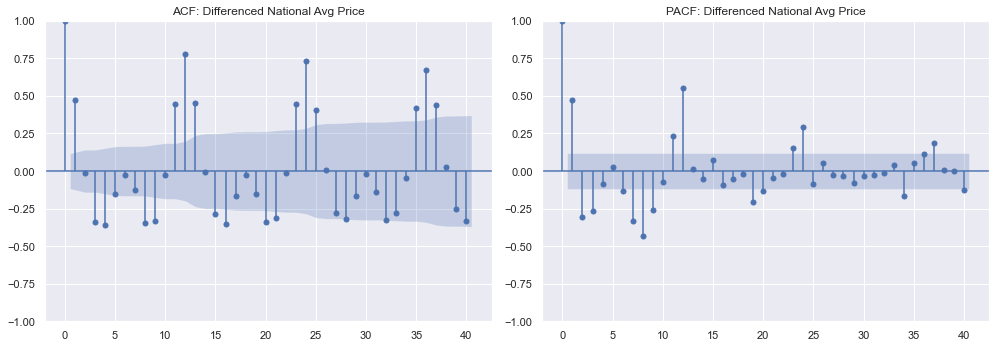

In [ ]:
# Plot ACF and PACF of the differenced series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(price_diff, lags=40, ax=axes[0], title="ACF: Differenced National Avg Price")

# PACF plot
plot_pacf(price_diff, lags=40, ax=axes[1], title="PACF: Differenced National Avg Price")

plt.tight_layout()
plt.show()

# Seasonality (yearly)


## Check: Trend?

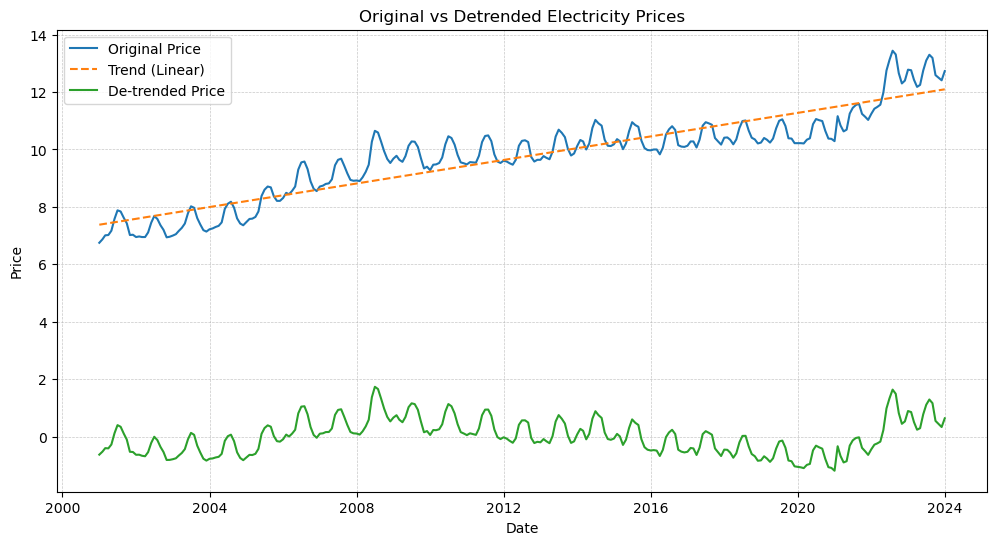

In [99]:
# Prepare data for de-trending
x = np.arange(1, 1 + len(price)).reshape(-1, 1)
y = price.to_numpy()

# Fit a linear regression model
trend_model = LinearRegression()
trend_model.fit(x, y)
trend = pd.Series(trend_model.predict(x), index=price.index)

# Calculate residuals (detrended series)
detrended = price - trend

plt.figure(figsize=(12, 6))
plt.plot(price, label="Original Price")
plt.plot(trend, label="Trend (Linear)", linestyle='--')
plt.plot(detrended, label="De-trended Price")
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.legend()
plt.title("Original vs Detrended Electricity Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# The data has somewhat of a linear trend so we will need to account for that in SARIMA


## Identify AR and MA terms for SARIMA
To analyze the autocorrelation structure and identify potential AR and MA terms for the ARIMA model.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


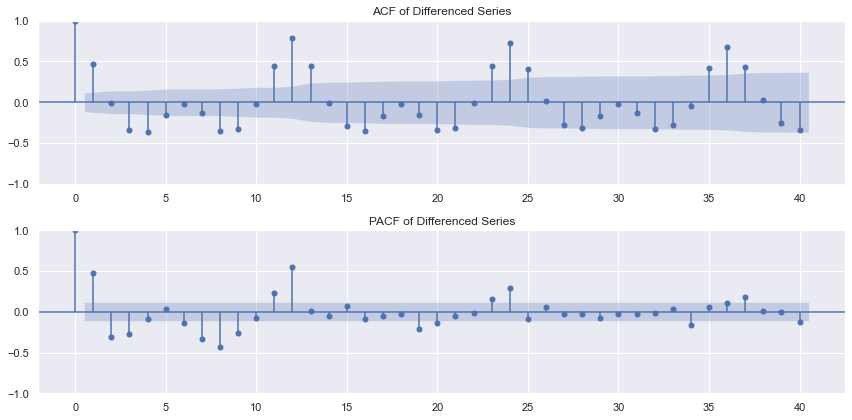

In [24]:
# Plot ACF and PACF for the detrended and normalized series
plt.figure(figsize=(12, 6))

# ACF Plot
plt.subplot(211)
plot_acf(price_diff, lags=40, ax=plt.gca())
plt.title("ACF of Differenced Series")

# PACF Plot
plt.subplot(212)
plot_pacf(price_diff, lags=40, ax=plt.gca())
plt.title("PACF of Differenced Series")

plt.tight_layout()
plt.show()


## Grid Search for Best SARIMA Model
Fit SARIMA models on the detrended_normalized series and find the best parameters based on AIC.

In [59]:
# Define parameter grids for SARIMA
p = range(0, 3)         # AR terms
d = range(0, 2)         # Differencing
q = range(0, 3)         # MA terms
P = range(0, 3)         # Seasonal AR terms
D = range(0, 2)         # Seasonal Differencing
Q = range(0, 3)         # Seasonal MA terms
s = [12]                # Seasonality (monthly data)

# Create a grid of all parameter combinations
parameters = list(itertools.product(p, d, q, P, D, Q, s))

tscv = TimeSeriesSplit(n_splits=5)

# Perform grid search
best_rmse = float("inf")
best_params = None
best_model = None
avg_rmses = []

# Perform cross-validation to find parameters that minimize RMSE
for i, param in enumerate(parameters):
    if i % 20 == 0:
        print(f"Trying model {i+1}/{len(parameters)}")
    try:
        rmse_list = []
        for train_index, test_index in tscv.split(detrended):
            train, test = price.iloc[train_index], price.iloc[test_index]
            model = SARIMAX(
                train,
                order=(param[0], param[1], param[2]),
                seasonal_order=(param[3], param[4], param[5], param[6]),
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            results = model.fit(disp=False)
            predictions = results.forecast(steps=len(test))
            rmse = root_mean_squared_error(test, predictions)
            rmse_list.append(rmse)
        
        avg_rmse = np.mean(rmse_list)
        avg_rmses.append(avg_rmse)
        
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_params = param
            best_model = results
    except Exception as e:
        continue

# Output best parameters and RMSE
print(f"Best SARIMA parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")


Trying model 1/324
Trying model 21/324
Trying model 41/324
Trying model 61/324
Trying model 81/324
Trying model 101/324
Trying model 121/324
Trying model 141/324
Trying model 161/324
Trying model 181/324
Trying model 201/324
Trying model 221/324
Trying model 241/324
Trying model 261/324
Trying model 281/324
Trying model 301/324
Trying model 321/324
Best SARIMA parameters: (2, 0, 0, 1, 1, 2, 12)
Best RMSE: 0.6660925889561458


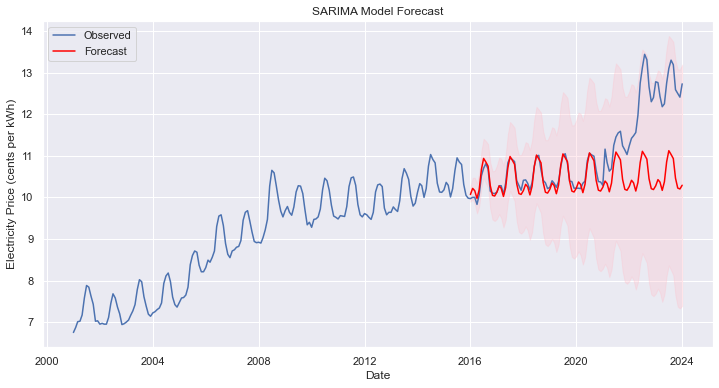

In [55]:
n_train = 180
train = price[:n_train]

best_params = [2, 0, 0, 1, 1, 2, 12]

# Fit the SARIMA model
# Fit the SARIMA model on the entire price series using the best parameters
model = SARIMAX(
    train,
    order=best_params[:3],
    seasonal_order=best_params[3:],
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = model.fit(disp=False)

# Forecast future values
forecast_steps = len(price) - n_train  # Number of steps to forecast
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean0 = forecast.predicted_mean
forecast_conf_int0 = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(price, label='Observed')
plt.plot(forecast_mean0, label='Forecast', color='red')
plt.fill_between(forecast_conf_int0.index, 
                 forecast_conf_int0.iloc[:, 0], 
                 forecast_conf_int0.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Electricity Price (cents per kWh)')
plt.legend()
plt.show()

# Print forecasted values
#print("Forecasted values:")
#print(forecast_mean)


In [102]:
# Compute average RMSE of the model on TimeSeriesSplit cross-validation
errors = []

for train_index, test_index in tscv.split(price):
    train, test = price.iloc[train_index], price.iloc[test_index]
    model = SARIMAX(
        train,
        order=best_params[:3],
        seasonal_order=best_params[3:],
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    results = model.fit(disp=False)
    predictions = results.forecast(steps=len(test))
    rmse = root_mean_squared_error(price.iloc[test_index], predictions)
    errors.append(rmse)

avg_rmse = np.mean(errors)
print(f"Average RMSE from TimeSeriesSplit cross-validation: {avg_rmse}")


Average RMSE from TimeSeriesSplit cross-validation: 0.6660925889561458


-110.50638833735117


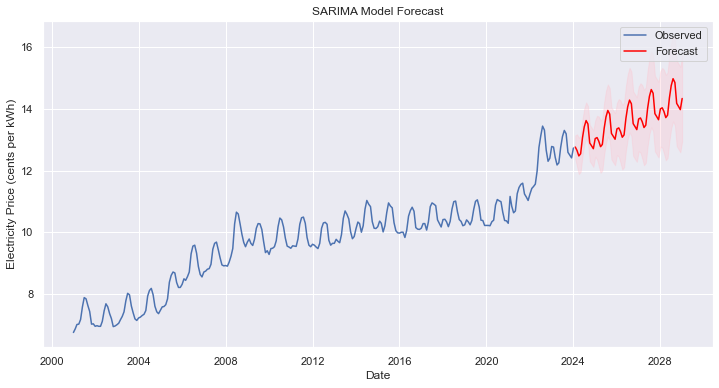

In [ ]:
best_model = SARIMAX(
    price,
    order=best_params[:3],
    seasonal_order=best_params[3:],
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = best_model.fit(disp=False)
print(results.aic)

# Forecast future values
forecast_steps = 60  # Number of steps to forecast
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(price, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Electricity Price (cents per kWh)')
plt.legend()
plt.show()


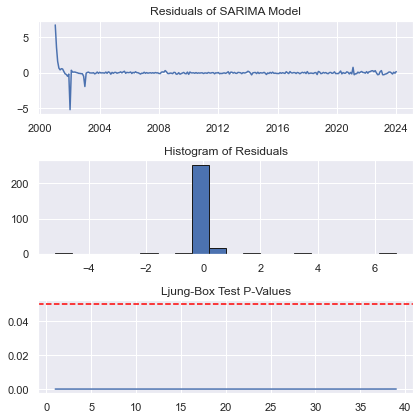

Residuals are not white noise (reject null hypothesis).


In [125]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Residuals of the best model
residuals = results.resid

# Plot residuals
plt.figure(figsize=(6, 6))
plt.subplot(311)
plt.plot(residuals)
plt.title("Residuals of SARIMA Model")

plt.subplot(312)
plt.hist(residuals, bins=20, edgecolor='k')
plt.title("Histogram of Residuals")


# Ljung-Box Test
lb_test = acorr_ljungbox(residuals, lags=range(40), return_df=True)

plt.subplot(313)
plt.plot(lb_test['lb_pvalue'])
plt.axhline(0.05, color='red', linestyle='--')
plt.title("Ljung-Box Test P-Values")
plt.tight_layout()
plt.show()


if lb_test['lb_pvalue'].mean() > 0.05:
    print("Residuals appear to be white noise (fail to reject null hypothesis).")
else:
    print("Residuals are not white noise (reject null hypothesis).")


# SARIMA with Detrended Data

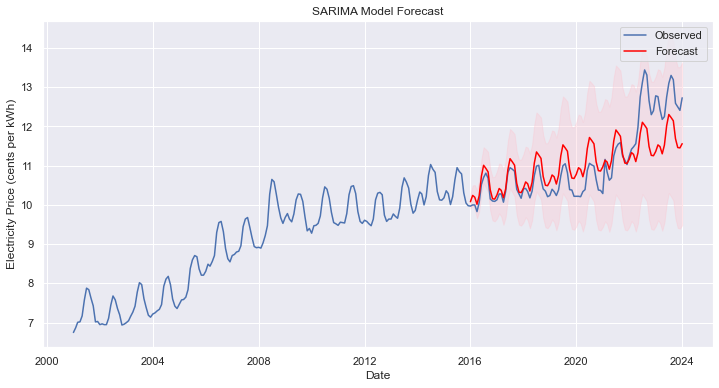

In [53]:
# NOTE: It can be shown that best params for detrended series are the same as for original series
# Need to include CV code that shows this, but it takes a while to run

n_train = 180
train = detrended[:n_train]

best_params = [2, 0, 0, 1, 1, 2, 12]

# Fit the SARIMA model
# Fit the SARIMA model on the entire price series using the best parameters
model = SARIMAX(
    train,
    order=best_params[:3],
    seasonal_order=best_params[3:],
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = model.fit(disp=False)

# Forecast future values
forecast_steps = len(detrended) - n_train  # Number of steps to forecast
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean1 = forecast.predicted_mean
forecast_conf_int1 = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(price, label='Observed')
plt.plot(forecast_mean1 + trend[n_train:], label='Forecast', color='red')
plt.fill_between(forecast_conf_int1.index, 
                 forecast_conf_int1.iloc[:, 0] + trend[n_train:], 
                 forecast_conf_int1.iloc[:, 1] + trend[n_train:], 
                 color='pink', alpha=0.3)
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Electricity Price (cents per kWh)')
plt.legend()
plt.show()

# Print forecasted values
#print("Forecasted values:")
#print(forecast_mean)


In [68]:
n_train = 180
train = detrended[:n_train]

best_params = [2, 0, 0, 1, 1, 2, 12]

# Compute average RMSE of the model on TimeSeriesSplit cross-validation
errors = []

for train_index, test_index in tscv.split(detrended):
    train, test = detrended.iloc[train_index], detrended.iloc[test_index]
    model = SARIMAX(
        train,
        order=best_params[:3],
        seasonal_order=best_params[3:],
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    results = model.fit(disp=False)
    predictions = results.forecast(steps=len(test))
    rmse = root_mean_squared_error(price.iloc[test_index], predictions + trend.iloc[test_index])
    errors.append(rmse)

avg_rmse = np.mean(errors)
print(f"Average RMSE from TimeSeriesSplit cross-validation: {avg_rmse}")


Average RMSE from TimeSeriesSplit cross-validation: 1.2168657875928366


-320.31379674549925


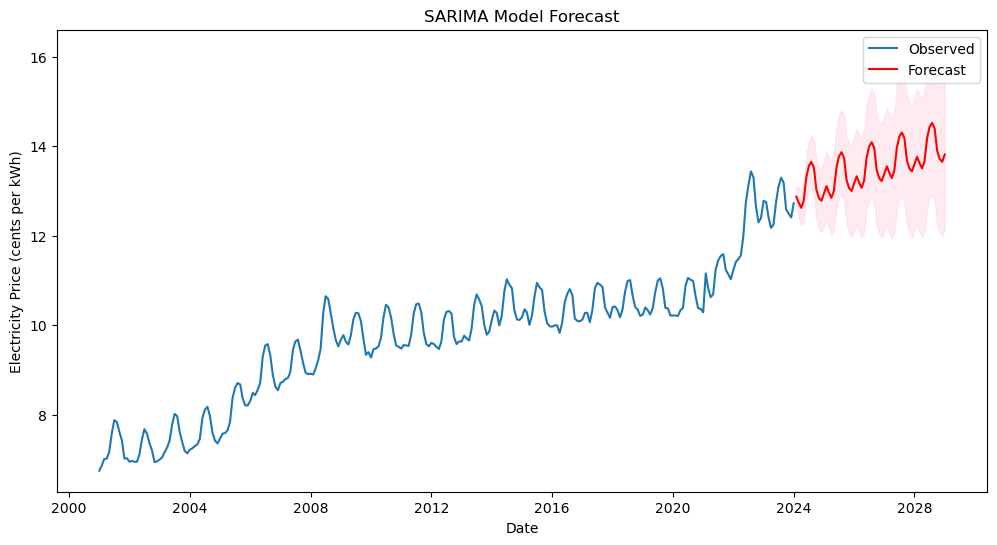

In [100]:
best_params = [2, 0, 0, 1, 1, 2, 12]

best_model = SARIMAX(
    detrended,
    order=best_params[:3],
    seasonal_order=best_params[3:],
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = best_model.fit(disp=False)
print(results.aic)

# Forecast future values
forecast_steps = 60  # Number of steps to forecast
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

trend_forecast = trend_model.predict(np.arange(len(price), len(price) + forecast_steps).reshape(-1, 1))

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(price, label='Observed')
plt.plot(forecast_mean + trend_forecast, label='Forecast', color='red')
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0] + trend_forecast, 
                 forecast_conf_int.iloc[:, 1] + trend_forecast, 
                 color='pink', alpha=0.3)
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Electricity Price (cents per kWh)')
plt.legend()
plt.show()


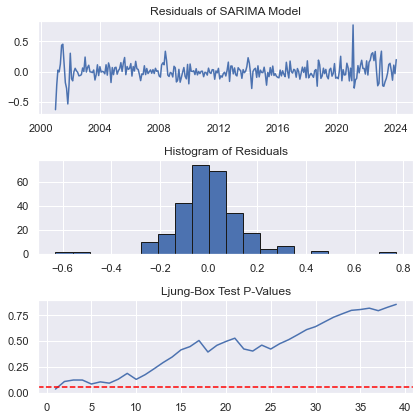

Residuals appear to be white noise (fail to reject null hypothesis).


In [127]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Residuals of the best model
residuals = results.resid

# Plot residuals
plt.figure(figsize=(6, 6))
plt.subplot(311)
plt.plot(residuals)
plt.title("Residuals of SARIMA Model")

plt.subplot(312)
plt.hist(residuals, bins=20, edgecolor='k')
plt.title("Histogram of Residuals")

# Ljung-Box Test
lb_test = acorr_ljungbox(residuals, lags=range(40), return_df=True)

plt.subplot(313)
plt.plot(lb_test['lb_pvalue'])
plt.axhline(0.05, color='red', linestyle='--')
plt.title("Ljung-Box Test P-Values")
plt.tight_layout()
plt.show()


if lb_test['lb_pvalue'].mean() > 0.05:
    print("Residuals appear to be white noise (fail to reject null hypothesis).")
else:
    print("Residuals are not white noise (reject null hypothesis).")


# SARIMAX: Temperature as Exogenous Variable

In [40]:
# Define parameter grids for SARIMA
p = range(0, 3)         # AR terms
d = range(0, 2)         # Differencing
q = range(0, 3)         # MA terms
P = range(0, 3)         # Seasonal AR terms
D = range(0, 2)         # Seasonal Differencing
Q = range(0, 3)         # Seasonal MA terms
s = [12]                # Seasonality (monthly data)

# Create a grid of all parameter combinations
parameters = list(itertools.product(p, d, q, P, D, Q, s))

tscv = TimeSeriesSplit(n_splits=5)

# Perform grid search
best_rmse = float("inf")
best_params = None
best_model = None
avg_rmses = []

# Perform cross-validation to find parameters that minimize RMSE
for i, param in enumerate(parameters):
    if i % 20 == 0:
        print(f"Trying model {i+1}/{len(parameters)}")
    try:
        rmse_list = []
        for train_index, test_index in tscv.split(detrended):
            train, test = price.iloc[train_index], price.iloc[test_index]
            model = SARIMAX(
                train,
                exog=temp_np[train_index],
                order=(param[0], param[1], param[2]),
                seasonal_order=(param[3], param[4], param[5], param[6]),
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            results = model.fit(disp=False)
            predictions = results.forecast(steps=len(test), exog=temp_np[test_index])
            rmse = root_mean_squared_error(test, predictions)
            rmse_list.append(rmse)
        
        avg_rmse = np.mean(rmse_list)
        avg_rmses.append(avg_rmse)
        
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_params = param
            best_model = results
    except Exception as e:
        continue

# Output best parameters and RMSE
print(f"Best SARIMA parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")


Trying model 1/324
Trying model 21/324
Trying model 41/324
Trying model 61/324
Trying model 81/324
Trying model 101/324
Trying model 121/324
Trying model 141/324
Trying model 161/324
Trying model 181/324
Trying model 201/324
Trying model 221/324
Trying model 241/324
Trying model 261/324
Trying model 281/324
Trying model 301/324
Trying model 321/324
Best SARIMA parameters: (0, 1, 0, 0, 1, 2, 12)
Best RMSE: 0.6447495953654011


In [69]:
n_train = 180
train = detrended[:n_train]

best_params = [0, 1, 0, 0, 1, 2, 12]

# Compute average RMSE of the model on TimeSeriesSplit cross-validation
errors = []

for train_index, test_index in tscv.split(detrended):
    train, test = detrended.iloc[train_index], detrended.iloc[test_index]
    model = SARIMAX(
        train,
        exog=temp_np[train_index],
        order=best_params[:3],
        seasonal_order=best_params[3:],
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    results = model.fit(disp=False)
    predictions = results.forecast(steps=len(test), exog=temp_np[test_index])
    rmse = root_mean_squared_error(price.iloc[test_index], predictions + trend.iloc[test_index])
    errors.append(rmse)

avg_rmse = np.mean(errors)
print(f"Average RMSE from TimeSeriesSplit cross-validation: {avg_rmse}")


Average RMSE from TimeSeriesSplit cross-validation: 0.9334285747735453


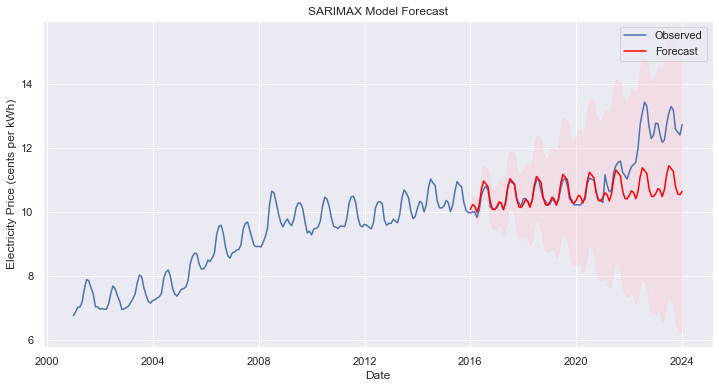

In [70]:
n_train = 180
train = detrended[:n_train]

best_params = [0, 1, 0, 0, 1, 2, 12]

# Fit the SARIMA model
# Fit the SARIMA model on the entire price series using the best parameters
model = SARIMAX(
    train,
    exog=temp_np[:n_train],
    order=best_params[:3],
    seasonal_order=best_params[3:],
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = model.fit(disp=False)

# Forecast future values
forecast_steps = len(price) - n_train  # Number of steps to forecast
forecast = results.get_forecast(steps=forecast_steps, exog=temp_np[n_train:])
forecast_mean2 = forecast.predicted_mean
forecast_conf_int2 = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(price, label='Observed')
plt.plot(forecast_mean2 + trend[n_train:], label='Forecast', color='red')
plt.fill_between(forecast_conf_int2.index, 
                 forecast_conf_int2.iloc[:, 0] + trend[n_train:], 
                 forecast_conf_int2.iloc[:, 1] + trend[n_train:], 
                 color='pink', alpha=0.3)
plt.title('SARIMAX Model Forecast')
plt.xlabel('Date')
plt.ylabel('Electricity Price (cents per kWh)')
plt.legend()
plt.show()

# Print forecasted values
#print("Forecasted values:")
#print(forecast_mean)


In [84]:
best_params = [0, 1, 0, 0, 1, 2, 12]
best_model_x = SARIMAX(
    detrended,
    exog=temp_np,
    order=best_params[:3],
    seasonal_order=best_params[3:],
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = best_model_x.fit(disp=False)
print(results.aic)
#results.summary()
results.params


-323.06737908052935


x1         -0.004930
ma.S.L12   -0.793085
ma.S.L24    0.005641
sigma2      0.014312
dtype: float64

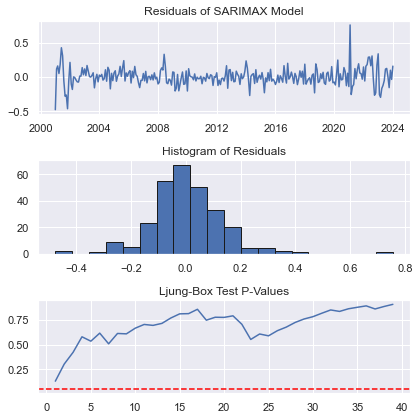

Residuals appear to be white noise (fail to reject null hypothesis).


In [65]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Residuals of the best model
residuals = results.resid

# Plot residuals
plt.figure(figsize=(6, 6))
plt.subplot(311)
plt.plot(residuals)
plt.title("Residuals of SARIMAX Model")

plt.subplot(312)
plt.hist(residuals, bins=20, edgecolor='k')
plt.title("Histogram of Residuals")

# Ljung-Box Test
lb_test = acorr_ljungbox(residuals, lags=range(40), return_df=True)

plt.subplot(313)
plt.plot(lb_test['lb_pvalue'])
plt.axhline(0.05, color='red', linestyle='--')
plt.title("Ljung-Box Test P-Values")
plt.tight_layout()
plt.show()


if lb_test['lb_pvalue'].mean() > 0.05:
    print("Residuals appear to be white noise (fail to reject null hypothesis).")
else:
    print("Residuals are not white noise (reject null hypothesis).")


# Comparison

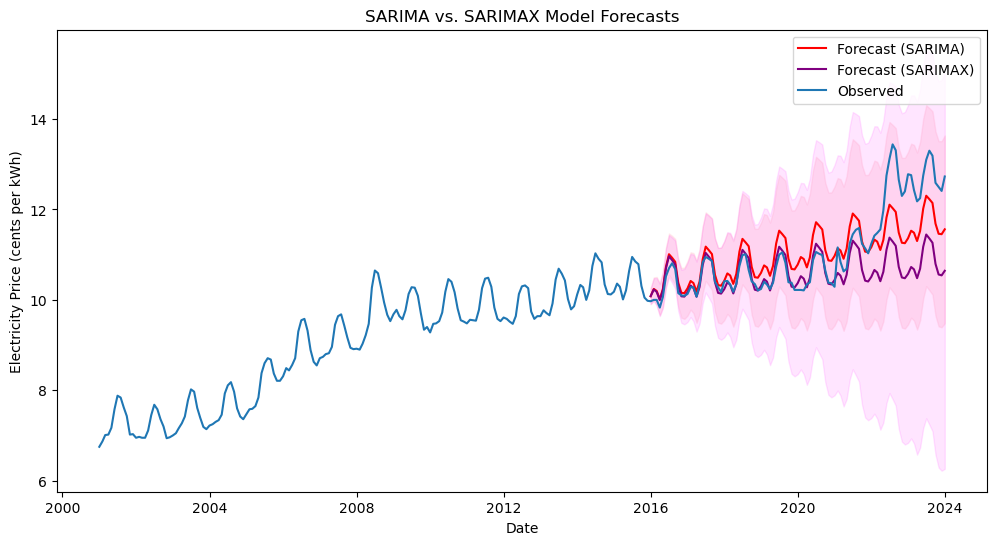

In [102]:
# NOTE: It can be shown that best params for detrended series are the same as for original series
# Need to include CV code that shows this, but it takes a while to run



# Plot the forecast
plt.figure(figsize=(12, 6))

#plt.plot(forecast_mean0, label='Forecast (Original)', color='red')
#plt.fill_between(forecast_conf_int0.index, 
#                 forecast_conf_int0.iloc[:, 0], 
#                 forecast_conf_int0.iloc[:, 1], 
#                 color='pink', alpha=0.1)

plt.plot(forecast_mean1 + trend[n_train:], label='Forecast (SARIMA)', color='red')
plt.fill_between(forecast_conf_int1.index, 
                 forecast_conf_int1.iloc[:, 0] + trend[n_train:], 
                 forecast_conf_int1.iloc[:, 1] + trend[n_train:], 
                 color='pink', alpha=0.3)

plt.plot(forecast_mean2 + trend[n_train:], label='Forecast (SARIMAX)', color='purple')
plt.fill_between(forecast_conf_int2.index, 
                 forecast_conf_int2.iloc[:, 0] + trend[n_train:], 
                 forecast_conf_int2.iloc[:, 1] + trend[n_train:], 
                 color='magenta', alpha=0.1)

plt.plot(price, label='Observed')


plt.title('SARIMA vs. SARIMAX Model Forecasts')
plt.xlabel('Date')
plt.ylabel('Electricity Price (cents per kWh)')
plt.legend()
plt.show()

